<h1><center><font size="5">Webscrapping  the Durban fresh produce market data</font></center></h1>

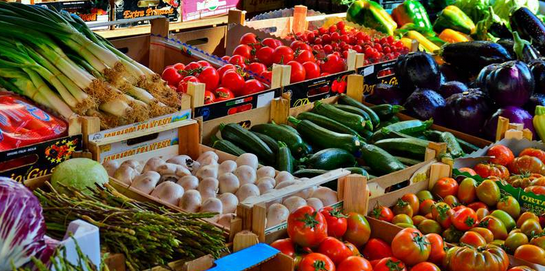

# <a id='0'>Contents</a>


* [1. Package and Module Imports](#Package_and_module_imports)
* [2. Webscrapping Durban fresh produce data](#scrapping)
* [3. Data Description and Cleaning](#Describe)
    * [3.1. Column description](#column_describe)
    * [3.2. Data Cleaning](#clean_data)
* [4. Data Normalization](#Data_Normalize)
    * [4.1. Products Table](#Products)
    * [4.2. Province Table](#Province)
    * [4.3. Contianer Table](#Container)
    * [4.4. Master Date Table](#Master_date)
    * [4.5. Inventory Table](#Inventory)
    * [4.6. Product Combination Table](#Product_combination)
    * [4.7. Sales Table](#Sales)
* [5. Saving Normalized tables  into SQL table](#Save_data)
* [6. Closing all connections](#close)
  

<a id="Package_and_module_imports"></a>
# <a id="1">1. Package and Module Imports</a>  

In [80]:
#Packages for webscrapping
from bs4 import BeautifulSoup
from selenium import webdriver

#additional packages
import pandas as pd
import pyodbc
import warnings
warnings.filterwarnings('ignore')

## <a id=""> Creating an SQL Connection</a>  

In [86]:
#Creating a connection
conn = pyodbc.connect(driver='{SQL Server}',
                      host='DESKTOP-0SIPQ7F\SQLEXPRESS',
                      database='Fresh_Produce_Market_Data', #Database name
                      trusted_connection='tcon',
                      user='sa')

# Return a new Cursor object using the connection.
cur = conn.cursor()

<a id="scrapping"></a>
# <a id="2">2. Webscrapping Durban fresh produce data</a>  

In this section we will webscrape the freshproduce markert data from the Durban freshproduce market **http://www.durban.gov.za/Online_Tools/Pages/Fresh_Produce_Price_Reporting.aspx**

In [82]:
#Creating a webdriver using selenium
driver=webdriver.Firefox()
driver.get('http://www.durban.gov.za:152/')

In [83]:
#Parse the html content from selenium webdriver to BeautifulSoup
soup = BeautifulSoup(driver.page_source, "html.parser")

The below function webscrapes the HTML content stored in BeautifulSoup

In [84]:
def scrape_table(html_content):
    """
    Function takes HTML page content stored in BeautifulSoup scrapes it and returns the output as a Dataframe. 

    Parameter(s):
    -------------
    html_content: HTML content stored in BeautifulSoup
    
    Return
    ------
    DataFrame:
    
    """
    
    #Extracting the column name
    table=html_content.find('table')
    columns=[col.text.strip() for col in table.find_all('th')]
    columns[0]='Commodities'
    
    #Extracting all the items
    rows=table.find_all('tr')[1:]
    items=[[row.text.strip() for row in item.find_all('td')] for item in rows]
    
    #Saving output as a DataFrame
    df=pd.DataFrame(items, columns=columns)
    
    return df

In [85]:
Durban_df=scrape_table(soup)
Durban_df.head()

,Commodities,Weight (Kg),Size Grade,Container,Province,Low Price,High Price,Average Price,Sales Total,Total Qty Sold,Total Kg Sold,Stock On Hand,Date
0,ABC JUICE,3.30,,OC033,TRANSVAAL,65.22,65.22,65.22,195.66,3,9.9,639,23/Nov/2020
1,ABC JUICE,7.50,,OD075,TRANSVAAL,0.00,0.00,0.00,0,0,0,141,23/Nov/2020
2,APPLE,0.33,,OA003,TRANSVAAL,4.89,6.52,5.12,717.2,140,46.2,140,23/Nov/2020
3,APPLE,3.30,,OC033,TRANSVAAL,0.00,0.00,0.00,0,0,0,3,23/Nov/2020
4,APPLE,7.50,,OD075,TRANSVAAL,110.30,110.30,110.30,882.4,8,60,33,23/Nov/2020


## <a id=""> Saving raw data into SQL</a>  

In [87]:
#Inserting data into an sql database
for index,row in Durban_df.iterrows():
    cur.execute("INSERT INTO Durban_Fresh_produce_market(Commodities, Weight_Kg, Size_Grade,Container,Province,Low_Price,High_Price,Average_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,Date) Values(?,?,?,?,?,?,?,?,?,?,?,?,?)",
                row['Commodities'],
                row['Weight (Kg)'],
                row['Size Grade'],
                row['Container'],
                row['Province'],
                row['Low Price'],
                row['High Price'],
                row['Average Price'],
                row['Sales Total'],
                row['Total Qty Sold'],
                row['Total Kg Sold'],
                row['Stock On Hand'],
                row['Date'])
    
    conn.commit()

<a id="Describe"></a>
# <a id="3">3. Data Description and Cleaning</a>  

In this section we will describe our data coulmns and further clean the data so that it is in a good form for data normalization

## 3.1. Column Description<a id="column_describe"></a>

**Commodities**: This column contains commodity information such as your comodity types( Apples,Bananas, Cabbage.. etc)
<br>

**Weight (Kg)**    : Weight of each commodity

**Size Grade**     : Grade Size of each commodity whether it is small,medium or larger and whether it is class type 1,2 or 3

**Container**      :  The container code contains  the contianer information for each commodity e.g (**M4183** )is equaivalent to **(MARK 4 (18.3kg))** Where the first two digits in the code describes the contianer name and the last 3 digits decribes the comodity size in KG

**Province**       : Province or a place where the commodity stock was bought from.

**Low Price**       : Commodity low price.

**High Price**      : Commodity high price.

**Average Price**   : Commodity average price

**Sales Total**     : Total Sales

**Total Qty Sold**    : Total sales in KG's

**Stock On Hand**     : Available stock 

**Date**              : Commodity purchase date from the frsh produce market

## <a id=""> Loading raw data from SQL table</a>  

In [88]:
Durban_df = pd.read_sql_query('select * from dbo.Durban_Fresh_produce_market',conn)

## 3.2. Data Cleaning<a id="clean_data"></a>

In this section we will clean our data and formalize it in a way that will be good for our project.

In [89]:
def clean_data(df):
    
    """
    Function that takes raw data and clean it.

    Parameter(s):
    -------------
    df:DataFrame
    
    Return
    ------
    DataFrame: Cleaned DataFrame
    
    """
    
    df.columns = df.columns.str.replace(' ','_')
    df=df.rename(columns={'Weight_(Kg)': 'Weight_Kg'})
    
    #Combining container information with KG size
    df['Container']=df['Container'].str[-3:] + 'KG' + ' (' + df['Container'] + ')'
    
    
    #converting all digital data to numeric
    df.Sales_Total = pd.to_numeric(df.Sales_Total)
    df.Total_Qty_Sold=pd.to_numeric(df.Total_Qty_Sold)
    df.High_Price=pd.to_numeric(df.High_Price)
    df.Low_Price=pd.to_numeric(df.Low_Price)
    df.Average_Price=pd.to_numeric(df.Average_Price)
    df.Stock_On_Hand=pd.to_numeric(df.Stock_On_Hand)
    df.Total_Kg_Sold=pd.to_numeric(df.Total_Kg_Sold)
    
    
    #Excluding data with sales amount as zero
    df=df[df.Sales_Total >0]
    
    #Consolidating / grouping  all the products
    df = df.groupby(['Province', 'Container', 'Size_Grade', 'Weight_Kg', 'Commodities', 'Date'])[['Low_Price', 'High_Price', 'Sales_Total', 'Total_Qty_Sold', 'Total_Kg_Sold', 'Stock_On_Hand','Average_Price']].agg(
        {
            'Low_Price':min,
            'High_Price':max,
            'Average_Price':min,
            'Sales_Total':sum,
            'Total_Qty_Sold':sum,
            'Total_Kg_Sold':sum,
            'Stock_On_Hand':sum
        })
    
    #Reseting the index
    df.reset_index(inplace=True)
    
    #Converting date to date_time
    df['Date']=pd.to_datetime(df['Date'])
    
    df.sort_values(by=['Container'], inplace=True)
 
    
    
    return df

In [90]:
df_cleaned=clean_data(Durban_df)
df_cleaned.head()

,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Average_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand
28039,NATAL,001KG (A1001),1S,0.12,GARLIC LOCAL,2020-07-09,20.0,24.0,22.0,360.0,16.0,1.92,376.0
28038,NATAL,001KG (A1001),1S,0.12,GARLIC LOCAL,2020-06-08,24.0,24.0,24.0,264.0,11.0,1.32,269.0
28037,NATAL,001KG (A1001),1S,0.12,GARLIC LOCAL,2020-07-08,24.0,24.0,24.0,192.0,8.0,0.96,376.0
28036,NATAL,001KG (A1001),1S,0.12,GARLIC LOCAL,2020-05-07,28.0,28.0,28.0,28.0,1.0,0.12,63.0
28035,NATAL,001KG (A1001),1S,0.12,GARLIC LOCAL,2020-07-07,20.0,20.0,20.0,100.0,5.0,0.60,192.0


A function that extract product name and decription from the commodity

In [92]:
def extract_product_name_description(df,commodity_column):
    
    """
    Function that extract product name and description from commodity.

    Parameter(s):
    -------------
    df:DataFrame
    commodity_column: Column with commodity information
    
    Return
    ------
    DataFrame: DataFrame with extra two columns containing product name and description
    
    """
    
    #Extracting product name and product description
    product_name=[]
    product_description=[]
    for item in df[commodity_column]:
        item=item.replace('-',' ')
        if len(item.split())<2:
            prod=item
            description=item

        elif 'SWEET' in item or 'ABC' in item or 'GEM' in item or 'ZOBO' in item :
            prod=' '.join(item.split()[:2])
            description=' '.join(item.split())
        else:
            prod=item.split()[0]
            description=' '.join(item.split())

        product_name.append(prod)
        product_description.append(description)
        
        
    #assigning product name and description
    df['product_name']=product_name
    df['product_description']=product_description
    
    return df

In [93]:
df_cleaned=extract_product_name_description(df_cleaned,'Commodities')
df_cleaned.head()

,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Average_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,product_name,product_description
28039,NATAL,001KG (A1001),1S,0.12,GARLIC LOCAL,2020-07-09,20.0,24.0,22.0,360.0,16.0,1.92,376.0,GARLIC,GARLIC LOCAL
28038,NATAL,001KG (A1001),1S,0.12,GARLIC LOCAL,2020-06-08,24.0,24.0,24.0,264.0,11.0,1.32,269.0,GARLIC,GARLIC LOCAL
28037,NATAL,001KG (A1001),1S,0.12,GARLIC LOCAL,2020-07-08,24.0,24.0,24.0,192.0,8.0,0.96,376.0,GARLIC,GARLIC LOCAL
28036,NATAL,001KG (A1001),1S,0.12,GARLIC LOCAL,2020-05-07,28.0,28.0,28.0,28.0,1.0,0.12,63.0,GARLIC,GARLIC LOCAL
28035,NATAL,001KG (A1001),1S,0.12,GARLIC LOCAL,2020-07-07,20.0,20.0,20.0,100.0,5.0,0.60,192.0,GARLIC,GARLIC LOCAL


<a id="Data_Normalize"></a>
# <a id="4">4. Data Normalization</a>  

In this section we will normalize our data before we store it on our database

## 4.1. Products Table<a id="Products"></a>

In [96]:
products=pd.DataFrame(df_cleaned['product_name'].unique(),columns=['name'])
products['id']=products.reset_index()['index']+1
products.head()

,name,id
0,GARLIC,1
1,SPINACH,2
2,CURRY,3
3,GINGER,4
4,PARSLEY,5


## 4.2. Province Table<a id="Province"></a>

In [95]:
province_place=pd.DataFrame(df_cleaned['Province'].unique(),columns=['name'])
province_place['id']=province_place.reset_index()['index']+1
province_place.head()

,name,id
0,NATAL,1
1,MPUMALANGA MIDVELD,2
2,TRANSVAAL,3
3,CAPE,4
4,NAMIBIA,5


## 4.3. Contianer Table<a id="Container"></a>

In [97]:
container=pd.DataFrame(df_cleaned['Container'].unique(),columns=['name'])
container['id']=container.reset_index()['index']+1
container.head()

,name,id
0,001KG (A1001),1
1,001KG (NA001),2
2,002KG (A9002),3
3,002KG (DA002),4
4,002KG (HR002),5


## 4.4. Master Date Table<a id="Master_date"></a>

In [98]:
master_date=pd.DataFrame(df_cleaned['Date'].unique(),columns=['date_key'])
master_date['calendar_date']=master_date['date_key'].dt.date
master_date['year']=master_date['date_key'].dt.year
master_date['half_of_year']=master_date['date_key'].dt.month.apply(lambda x: 1 if x<7 else 2)
master_date['quarter']=master_date['date_key'].dt.quarter
master_date['month']=master_date['date_key'].dt.month_name()
master_date['week_of_year']=master_date['date_key'].dt.week
master_date['day']=master_date['date_key'].dt.day_name()
master_date.head()

,date_key,calendar_date,year,half_of_year,quarter,month,week_of_year,day
0,2020-07-09,2020-07-09,2020,2,3,July,28,Thursday
1,2020-06-08,2020-06-08,2020,1,2,June,24,Monday
2,2020-07-08,2020-07-08,2020,2,3,July,28,Wednesday
3,2020-05-07,2020-05-07,2020,1,2,May,19,Thursday
4,2020-07-07,2020-07-07,2020,2,3,July,28,Tuesday


In [119]:
master_date.to_excel("Master_date.xlsx", index=False)

## 4.5. Inventory Table<a id="Inventory"></a>

In [99]:
inventory=df_cleaned[['Date','product_name','Container','Province','Stock_On_Hand']]
inventory['product_id']=inventory['product_name'].map(products.set_index('name')['id'])
inventory['container_id']=inventory['Container'].map(container.set_index('name')['id'])
inventory['province_id']=inventory['Province'].map(province_place.set_index('name')['id'])
inventory=inventory.drop(columns =['product_name', 'Container','Province'])
inventory['id']=inventory.reset_index()['index']+1
inventory

,Date,Stock_On_Hand,product_id,container_id,province_id,id
28039,2020-07-09,376.0,1,1,1,74121
28038,2020-06-08,269.0,1,1,1,74120
28037,2020-07-08,376.0,1,1,1,74119
28036,2020-05-07,63.0,1,1,1,74118
28035,2020-07-07,192.0,1,1,1,74117
...,...,...,...,...,...,...
26688,2020-02-12,68.0,125,235,8,71907
26663,2020-01-08,0.0,161,235,8,40350
26662,2020-02-01,72.0,161,235,8,40349
26664,2020-02-10,62.0,161,235,8,40351


## 4.6. Product Combination Table<a id="Product_combination"></a>

In [103]:
product_combination=pd.DataFrame(df_cleaned.Commodities)
product_combination['name']=df_cleaned['product_description'].astype(str) +','+ df_cleaned['Size_Grade'].astype(str)+','+ df_cleaned['Weight_Kg']
temp=pd.DataFrame(product_combination['name'].drop_duplicates(),columns=['name']).sort_values(by=['name'])
temp=temp.reset_index(drop=True)
temp['id']=temp.reset_index()['index']+1
product_combination['id']=product_combination['name'].map(temp.set_index('name')['id'])
product_combination

,Commodities,name,id
28039,GARLIC LOCAL,"GARLIC LOCAL,1S,0.12",783
28038,GARLIC LOCAL,"GARLIC LOCAL,1S,0.12",783
28037,GARLIC LOCAL,"GARLIC LOCAL,1S,0.12",783
28036,GARLIC LOCAL,"GARLIC LOCAL,1S,0.12",783
28035,GARLIC LOCAL,"GARLIC LOCAL,1S,0.12",783
...,...,...,...
26688,RED BEANS,"RED BEANS,,50.00",2755
26663,BROAD BEANS,"BROAD BEANS,,50.00",517
26662,BROAD BEANS,"BROAD BEANS,,50.00",517
26664,BROAD BEANS,"BROAD BEANS,,50.00",517


## 4.7. Sales Table<a id="Sales"></a>

In [105]:
sales=df_cleaned[['Total_Qty_Sold','Total_Kg_Sold','Average_Price','High_Price']]
sales['Date']=pd.DataFrame(df_cleaned['Date'])
sales['id']=sales.reset_index()['index']+1
sales['product_combination_id']=product_combination['id']
sales['container_id']=inventory['container_id']
sales['product_id']=inventory['product_id']
sales.Total_Qty_Sold=pd.to_numeric(sales.Total_Qty_Sold)
sales.High_Price=pd.to_numeric(sales.High_Price)
sales['value']=sales.Total_Qty_Sold.astype(float)*sales.High_Price.astype(float)
sales

,Total_Qty_Sold,Total_Kg_Sold,Average_Price,High_Price,Date,id,product_combination_id,container_id,product_id,value
28039,16.0,1.92,22.0,24.0,2020-07-09,74121,783,1,1,384.0
28038,11.0,1.32,24.0,24.0,2020-06-08,74120,783,1,1,264.0
28037,8.0,0.96,24.0,24.0,2020-07-08,74119,783,1,1,192.0
28036,1.0,0.12,28.0,28.0,2020-05-07,74118,783,1,1,28.0
28035,5.0,0.60,20.0,20.0,2020-07-07,74117,783,1,1,100.0
...,...,...,...,...,...,...,...,...,...,...
26688,1.0,50.00,700.0,700.0,2020-02-12,71907,2755,235,125,700.0
26663,10.0,500.00,650.0,650.0,2020-01-08,40350,517,235,161,6500.0
26662,1.0,50.00,675.0,675.0,2020-02-01,40349,517,235,161,675.0
26664,10.0,500.00,675.0,675.0,2020-02-10,40351,517,235,161,6750.0


## <a id=""> Product combination unique with unique ID</a>  

In [106]:
product_combination=temp
product_combination

,name,id
0,"ABC JUICE,,0.33",1
1,"ABC JUICE,,0.75",2
2,"ABC JUICE,,3.30",3
3,"ABC JUICE,0,0.33",4
4,"ABC JUICE,0,0.75",5
...,...,...
3256,"WATERMELON,X,12.00",3257
3257,"ZOBO BEETROOT INFUSED JUICE,,0.33",3258
3258,"ZOBO BEETROOT INFUSED JUICE,,0.75",3259
3259,"ZOBO BEETROOT INFUSED JUICE,,7.50",3260


<a id="Save_data"></a>
# <a id="5">5. Saving Normalized tables  into SQL table</a>  

Clearing the data on our tables

In [109]:
cur.execute('''DELETE FROM inventory_dbn''')
cur.execute('''DELETE FROM sales_dbn''')
cur.execute('''DELETE FROM province_dbn''')
cur.execute('''DELETE FROM product_dbn''')
cur.execute('''DELETE FROM product_combination_dbn''')
cur.execute('''DELETE FROM master_date_dbn''')
cur.execute('''DELETE FROM container_dbn''')
conn.commit()

### Saving products table on SQL

In [110]:
#Inserting data into an sql database
for index,row in products.iterrows():
    cur.execute("INSERT INTO product_dbn(id, name) Values(?,?)",
                row['id'],
                row['name'])
    
    conn.commit()

### Saving Province table on SQL

In [111]:
#Inserting data into an sql database
for index,row in province_place.iterrows():
    cur.execute("INSERT INTO province_dbn(id, name) Values(?,?)",
                row['id'],
                row['name'])
    
    conn.commit()

### Saving Container table on SQL

In [112]:
#Inserting data into an sql database
for index,row in container.iterrows():
    cur.execute("INSERT INTO container_dbn(id, name) Values(?,?)",
                row['id'],
                row['name'])
    
    conn.commit()

### Saving inventory table on SQL

In [113]:
for index,row in inventory.iterrows():
    cur.execute("INSERT INTO inventory_dbn(id,Date,Stock_On_Hand,product_id,container_id,province_id) Values(?,?,?,?,?,?)",
                row['id'],
                row['Date'],
                row['Stock_On_Hand'],
                row['product_id'],
                row['container_id'],
                row['province_id'])
    
    conn.commit()

### Saving product_combination table on SQL

In [114]:
#Inserting data into an sql database
for index,row in product_combination.iterrows():
    cur.execute("INSERT INTO product_combination_dbn(id, name) Values(?,?)",
                row['id'],
                row['name'])
    
    conn.commit()

### Saving sales table on SQL

In [120]:
for index,row in sales.iterrows():
    cur.execute("INSERT INTO sales_dbn(id,date,Total_Qty_Sold,Total_Kg_Sold,value,Average_Price,High_Price,product_combination_id,container_id,product_id) Values(?,?,?,?,?,?,?,?,?,?)",
                row['id'],
                row['Date'],
                row['Total_Qty_Sold'],
                row['Total_Kg_Sold'],
                row['value'],
                row['Average_Price'],
                row['High_Price'],
                row['product_combination_id'],
                row['container_id'],
                row['product_id'])
    
    conn.commit()

<a id="close"></a>
# <a id="6">6. Closing all connections</a>  

In [121]:
driver.close()
cur.close()  
conn.close()